In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import division
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
%matplotlib inline

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [3]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size)* scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)

In [4]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
content = load_image('../data/input.png', transform, max_size=400)
style = load_image('../data/style.png', transform, shape=[content.size(2), content.size(3)])

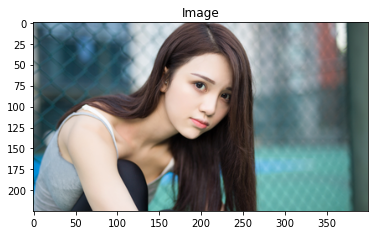

In [6]:
imshow(content[0], title='Image')

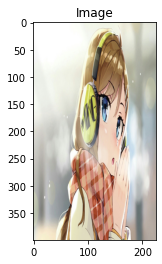

In [7]:
imshow(style[0], title='Image')

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
content = load_image('../data/input.png', transform, max_size=400)
style = load_image('../data/style.png', transform, shape=[content.size(2), content.size(3)])

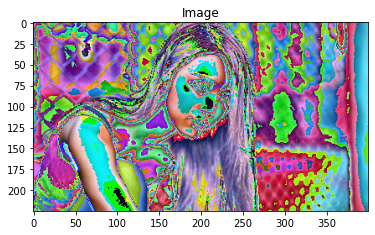

In [9]:
imshow(content[0], title='Image')

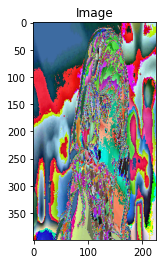

In [10]:
imshow(style[0], title='Image')

In [11]:
content.shape, style.shape

(torch.Size([1, 3, 225, 400]), torch.Size([1, 3, 400, 225]))

In [12]:
class VGG_Net(nn.Module):
    def __init__(self):
        super(VGG_Net, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

vgg = VGG_Net().to(device).eval()

In [13]:
# vgg = models.vgg19(pretrained=True)

In [14]:
# vgg.features

In [15]:
features = vgg(content)

C:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
# print(type(features))
# len(features)

In [17]:
for feat in features:
    print(feat.shape)

torch.Size([1, 64, 225, 400])
torch.Size([1, 128, 112, 200])
torch.Size([1, 256, 56, 100])
torch.Size([1, 512, 28, 50])
torch.Size([1, 512, 14, 25])


In [18]:
target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])

In [19]:
total_step = 2000
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    content_loss = style_loss = 0.
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2) / (c*h*w)
        
    loss = content_loss + style_loss * 100.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print('step [{}/{}], Content Loss: {:.4f}, Stype Loss: {:.4f}'.format(step, total_step, content_loss.item(), style_loss.item()))

step [0/2000], Content Loss: 0.0000, Stype Loss: 361.9696
step [10/2000], Content Loss: 6.1623, Stype Loss: 242.9897
step [20/2000], Content Loss: 12.6499, Stype Loss: 160.8611
step [30/2000], Content Loss: 15.8381, Stype Loss: 119.7836
step [40/2000], Content Loss: 17.7792, Stype Loss: 97.0414
step [50/2000], Content Loss: 19.2173, Stype Loss: 82.7572
step [60/2000], Content Loss: 20.3163, Stype Loss: 73.0447
step [70/2000], Content Loss: 21.1821, Stype Loss: 66.0088
step [80/2000], Content Loss: 21.9092, Stype Loss: 60.6376
step [90/2000], Content Loss: 22.5228, Stype Loss: 56.3831
step [100/2000], Content Loss: 23.0561, Stype Loss: 52.8830
step [110/2000], Content Loss: 23.5215, Stype Loss: 49.9214
step [120/2000], Content Loss: 23.9397, Stype Loss: 47.3662
step [130/2000], Content Loss: 24.3295, Stype Loss: 45.1177
step [140/2000], Content Loss: 24.6855, Stype Loss: 43.1267
step [150/2000], Content Loss: 25.0134, Stype Loss: 41.3363
step [160/2000], Content Loss: 25.3213, Stype Los

step [1370/2000], Content Loss: 34.7266, Stype Loss: 7.6417
step [1380/2000], Content Loss: 34.7560, Stype Loss: 7.6019
step [1390/2000], Content Loss: 34.7880, Stype Loss: 7.5627
step [1400/2000], Content Loss: 34.8162, Stype Loss: 7.5240
step [1410/2000], Content Loss: 34.8491, Stype Loss: 7.4859
step [1420/2000], Content Loss: 34.8801, Stype Loss: 7.4480
step [1430/2000], Content Loss: 34.9122, Stype Loss: 7.4109
step [1440/2000], Content Loss: 34.9417, Stype Loss: 7.3742
step [1450/2000], Content Loss: 34.9738, Stype Loss: 7.3382
step [1460/2000], Content Loss: 35.0021, Stype Loss: 7.3022
step [1470/2000], Content Loss: 35.0307, Stype Loss: 7.2671
step [1480/2000], Content Loss: 35.0598, Stype Loss: 7.2323
step [1490/2000], Content Loss: 35.0865, Stype Loss: 7.1977
step [1500/2000], Content Loss: 35.1163, Stype Loss: 7.1638
step [1510/2000], Content Loss: 35.1440, Stype Loss: 7.1300
step [1520/2000], Content Loss: 35.1711, Stype Loss: 7.0971
step [1530/2000], Content Loss: 35.1967,

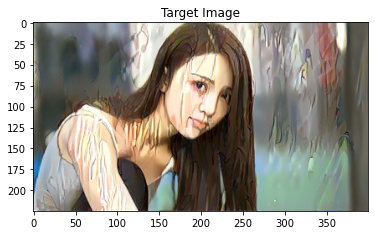

In [20]:
denorm = transforms.Normalize([-2.12, -2.04, -1.80], [4.37, 4.46, 4.44])
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
imshow(img, title='Target Image')